In [ ]:
!pip install -U datasets

In [1]:
import kagglehub
from datasets import load_dataset
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=UserWarning)

from transformers import logging
logging.set_verbosity_error()


In [2]:
Emotion_Dataset_Elvis_emotion = load_dataset("dair-ai/emotion", "split")

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [3]:
# Load the GoEmotions dataset
go_emotions_dataset = load_dataset("go_emotions")

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/350k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [4]:
# Download latest version
isear_dataset = kagglehub.dataset_download("faisalsanto007/isear-dataset")

print("Path to dataset files:", isear_dataset)

100%|██████████| 315k/315k [00:00<00:00, 53.4MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/faisalsanto007/isear-dataset/versions/1


In [ ]:
from datasets import load_dataset, Dataset, DatasetDict
from datasets import Features, ClassLabel, Value
import pandas as pd
from collections import Counter
from sklearn.utils import resample
import os

TARGET_EMOTIONS = {
    'anger': 'anger',
    'disgust': 'disgust',
    'fear': 'fear',
    'joy': 'happy',
    'love' : 'happy',
    'happy': 'happy',
    'sadness': 'sad',
    'sad': 'sad',
    'neutral': 'neutral',
    'surprise': 'surprise'
}

fine_to_coarse = {
    # 😠 Anger group
    'anger': 'anger',
    'annoyance': 'anger',
    'disapproval': 'anger',

    # 🤢 Disgust group
    'disgust': 'disgust',

    # 😨 Fear group
    'fear': 'fear',
    'nervousness': 'fear',

    # 😀 Happy group
    'joy': 'happy',
    'amusement': 'happy',
    'love': 'happy',
    'excitement': 'happy',
    'gratitude': 'happy',
    'optimism': 'happy',
    'pride': 'happy',
    'approval': 'happy',
    'relief': 'happy',
    'admiration': 'happy',
    'caring': 'happy',

    # 😐 Neutral
    'neutral': 'neutral',
    'realization': 'neutral',
    'curiosity': 'neutral',
    'confusion': 'neutral',
    'desire': 'neutral',

    # 😢 Sad group
    'sadness': 'sad',
    'grief': 'sad',
    'remorse': 'sad',
    'disappointment': 'sad',
    'embarrassment': 'sad',

    # 😲 Surprise group
    'surprise': 'surprise'
}


def map_emotion(label):
    label = str(label).strip().lower()
    return TARGET_EMOTIONS.get(label)

def map_go_emotion(label):
    label = str(label).strip().lower()
    return fine_to_coarse.get(label)

# 1. GoEmotions
def load_goemotions():
    ds = load_dataset("go_emotions", split="train")
    label_names = ds.features['labels'].feature.names  # Fix here

    # Only keep single-label entries and map to 7-class
    def extract_single_label(example):
        if len(example['labels']) == 1:
            label = label_names[example['labels'][0]]
            mapped = map_go_emotion(label)
            if mapped:
                return {'text': example['text'], 'label': mapped}
        return None

    # Filter and map
    processed = [extract_single_label(ex) for ex in ds if extract_single_label(ex) is not None]
    df = pd.DataFrame(processed)
    return df


# 2. Emotion Dataset (Elvis) {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
def load_emotion():
    ds = load_dataset("dair-ai/emotion", split="train+validation+test")
    df = ds.to_pandas()
    df['label'] = df['label'].apply(lambda x: map_emotion(ds.features['label'].int2str(x)))
    return df[['text', 'label']].dropna()


# 4. ISEAR ['anger', 'fear', 'joy', 'sadness']
def load_isear():
    df = pd.read_csv(f"{isear_dataset}/eng_dataset.csv")
    df['label'] = df['sentiment'].apply(map_emotion)
    return df[['content', 'label']].rename(columns={'content': 'text'}).dropna()


# Load all datasets
dfs = [
    load_goemotions(),
    load_emotion(),
    load_isear(),

]

# Step 1: Encode labels
label_list = ['anger', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Combine and shuffle
combined_df = pd.concat(dfs, ignore_index=True)
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

full_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Encode string labels to integer IDs
label_list = ['anger', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
label2id = {label: idx for idx, label in enumerate(label_list)}
full_df['label'] = full_df['label'].map(label2id)

from datasets import Dataset, DatasetDict, Features, ClassLabel, Value

features = Features({
    "text": Value("string"),
    "label": ClassLabel(names=label_list)
})

# Build Hugging Face Dataset
dataset = Dataset.from_pandas(full_df[["text", "label"]].reset_index(drop=True), features=features)

# Stratified split based on class labels
dataset = dataset.train_test_split(test_size=0.2, stratify_by_column="label")

final_dataset = DatasetDict({
    "train": dataset["train"],
    "validation": dataset["test"]
})


# Save locally
final_dataset.save_to_disk("/content/drive/MyDrive/Dissertation/Final_Datasets/combined_emotion_dataset_3_class_original")


Saving the dataset (0/1 shards):   0%|          | 0/50728 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/12682 [00:00<?, ? examples/s]

In [ ]:
load_goemotions()#good

,text,label
0,My favourite food is anything I didn't have to...,neutral
1,"Now if he does off himself, everyone will thin...",neutral
2,WHY THE FUCK IS BAYLESS ISOING,anger
3,To make her feel threatened,fear
4,Dirty Southern Wankers,anger
...,...,...
36303,Added you mate well I’ve just got the bow and ...,happy
36304,Always thought that was funny but is it a refe...,neutral
36305,What are you talking about? Anything bad that ...,anger
36306,"More like a baptism, with sexy results!",happy


In [ ]:
load_emotion()#good

,text,label
0,i didnt feel humiliated,sad
1,i can go from feeling so hopeless to so damned...,sad
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,happy
4,i am feeling grouchy,anger
...,...,...
19995,i just keep feeling like someone is being unki...,anger
19996,im feeling a little cranky negative after this...,anger
19997,i feel that i am useful to my people and that ...,happy
19998,im feeling more comfortable with derby i feel ...,happy


In [ ]:
load_isear()#good

,text,label
0,At the point today where if someone says somet...,anger
1,@CorningFootball IT'S GAME DAY!!!! T MIN...,anger
2,This game has pissed me off more than any othe...,anger
3,@spamvicious I've just found out it's Candice ...,anger
4,@moocowward @mrsajhargreaves @Melly77 @GaryBar...,anger
...,...,...
7097,@VivienLloyd Thank you so much! Just home - st...,sad
7098,Just put the winter duvet on ☃️❄️🌬☔️,sad
7099,@SilkInSide @TommyJoeRatliff that's so pretty!...,sad
7100,@BluesfestByron second artist announcement loo...,sad


In [ ]:
print(final_dataset)
print(final_dataset["train"].features)
final_dataset["train"][0]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 50728
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 12682
    })
})
{'text': Value('string'), 'label': ClassLabel(names=['anger', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])}


{'text': 'You have to be trolling because I doubt you’re this dumb.',
 'label': 0}

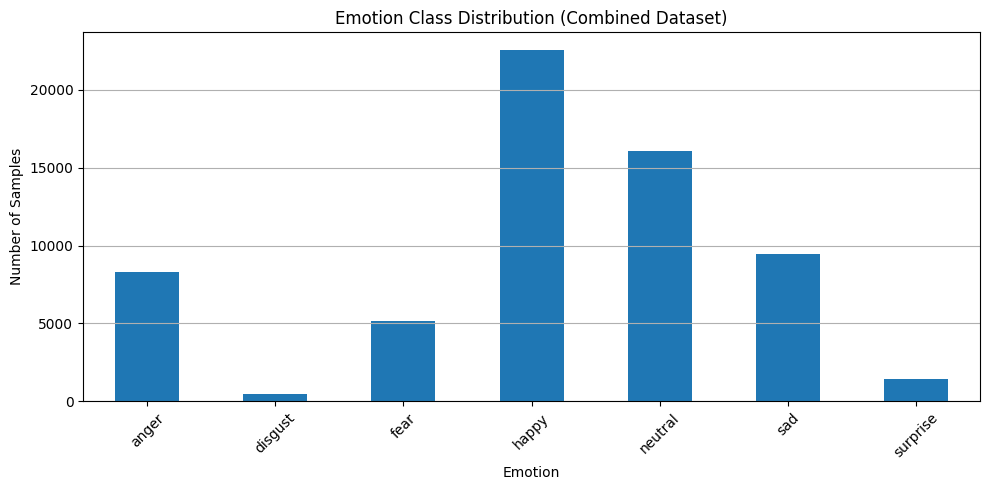

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from datasets import DatasetDict, load_from_disk

# Load the combined dataset
dataset = load_from_disk("/content/drive/MyDrive/Dissertation/Final_Datasets/combined_emotion_dataset_3_class_original")

# Convert to pandas for analysis
train_df = dataset["train"].to_pandas()
val_df = dataset["validation"].to_pandas()

# Combine for full analysis
full_df = pd.concat([train_df, val_df], ignore_index=True)

# Count of each label
label_counts = full_df['label'].value_counts().sort_index()

# Map label ids to class names
label_names = dataset["train"].features["label"].names
label_counts_named = label_counts.rename(index=dict(enumerate(label_names)))

# Plot distribution
plt.figure(figsize=(10, 5))
label_counts_named.plot(kind='bar')
plt.title("Emotion Class Distribution (Combined Dataset)")
plt.xlabel("Emotion")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()




In [ ]:
# Summary statistics
label_counts_named_df = label_counts_named.reset_index()
label_counts_named_df.columns = ['Emotion', 'Count']
label_counts_named_df["Percentage"] = (label_counts_named_df["Count"] / label_counts_named_df["Count"].sum() * 100).round(2)

In [ ]:
label_counts_named_df

,Emotion,Count,Percentage
0,anger,8288,13.07
1,disgust,498,0.79
2,fear,5140,8.11
3,happy,22549,35.56
4,neutral,16045,25.30
5,sad,9451,14.90
6,surprise,1439,2.27


In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"


model_name = 'humarin/chatgpt_paraphraser_on_T5_base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
import torch

def paraphrase_text(
    text,
    num_return_sequences=3,
    max_length=128,
    top_k=50,
    top_p=0.95,
    temperature=0.7
):
    input_text = f"paraphrase: {text} </s>"

    encoding = tokenizer(
        [input_text],
        padding='longest',
        return_tensors="pt"
    ).to(device)

    generated_ids = model.generate(
        **encoding,
        max_length=max_length,
        do_sample=True,
        top_k=top_k,
        top_p=top_p,
        temperature=temperature,
        num_return_sequences=num_return_sequences,
        early_stopping=True
    )
    paraphrases = tokenizer.batch_decode( generated_ids, skip_special_tokens=True)
    # Deduplicate
    paraphrases = list(set(paraphrases))

    return paraphrases




In [ ]:
!pip install nlpaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 9.4 MB/s eta 0:00:00


In [ ]:
counts = Counter(dataset['train']['label'])
print(counts)

Counter({3: 18039, 4: 12836, 5: 7561, 0: 6630, 2: 4112, 6: 1151, 1: 399})


In [ ]:
rare_class_ids = [label for label, count in counts.items() if count < 500]
print("Rare class IDs:", rare_class_ids)

Rare class IDs: [1]


In [ ]:
rare_dataset = dataset['train'].filter(lambda x: x['label'] in rare_class_ids)
rare_dataset#399+1151

Filter:   0%|          | 0/50728 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label'],
    num_rows: 399
})

In [ ]:
import random

def batch_paraphrase_fn(examples):
    new_texts = []
    labels = []

    for text, label in zip(examples['text'], examples['label']):
        try:
            paraphrases = paraphrase_text(
                text,
                num_return_sequences=3  # generate 3 at once
            )
            # Randomly pick one
            new_text = random.choice(paraphrases) if paraphrases else text
        except Exception as e:
            new_text = text

        new_texts.append(new_text)
        labels.append(label)

    return {'text': new_texts, 'label': labels}


In [ ]:
augmented_datasets = [
    rare_dataset.map(
        batch_paraphrase_fn,
        batched=True,
        batch_size=32
    ) for _ in range(3)
]


Map:   0%|          | 0/399 [00:00<?, ? examples/s]

In [ ]:
from datasets import concatenate_datasets

all_augmented = concatenate_datasets(augmented_datasets)
paraphrased_train = concatenate_datasets([dataset['train'], all_augmented])
paraphrased_train = paraphrased_train.shuffle(seed=42)

In [ ]:
399*3+399 #1151*2+1151

1596

In [ ]:
counts_1 = Counter(paraphrased_train['label'])
print(counts_1)#{0: 6630, 1: 399, 4: 12836, 5: 7561, 2: 4112, 3: 18039, 6: 1151}

Counter({3: 18039, 4: 12836, 5: 7561, 0: 6630, 2: 4112, 1: 1596, 6: 1151})


In [ ]:
paraphrased_train.save_to_disk("/content/drive/MyDrive/Dissertation/Final_Datasets/balanced_train_dataset_paraphrase_merged")

Saving the dataset (0/1 shards):   0%|          | 0/51925 [00:00<?, ? examples/s]

In [ ]:
paraphrased_train

Dataset({
    features: ['text', 'label'],
    num_rows: 51925
})

In [ ]:
rare_class_ids_1 = [label for label, count in counts_1.items() if count < 1600]
print("Rare class IDs:", rare_class_ids_1)

Rare class IDs: [1, 6]


In [ ]:
rare_dataset_1 = paraphrased_train.filter(lambda x: x['label'] in rare_class_ids_1)
rare_dataset_1#1596+1151

Dataset({
    features: ['text', 'label'],
    num_rows: 2747
})

In [ ]:
import nlpaug.augmenter.word as naw
from transformers import pipeline
import nlpaug.augmenter.word as naw

syn_aug = naw.SynonymAug(aug_src='wordnet')
context_aug = naw.ContextualWordEmbsAug(
    model_path='bert-base-uncased', action="substitute"
)

def augment_synonym(text):
    return syn_aug.augment(text)[0]

en2fr = pipeline('translation_en_to_fr', model='Helsinki-NLP/opus-mt-en-fr')
fr2en = pipeline('translation_fr_to_en', model='Helsinki-NLP/opus-mt-fr-en')

def augment_backtranslate(text):
    fr = en2fr(text)[0]['translation_text']
    bt = fr2en(fr)[0]['translation_text']
    return bt

def augment_ContextualWordEmbsAug(text):
    return context_aug.augment(text)[0]

In [ ]:
import random

def combined_augmentation(text):
    options = [
        augment_synonym,
        augment_backtranslate,
        augment_ContextualWordEmbsAug
    ]

    num_augs = random.randint(1, 2)
    chosen = random.sample(options, num_augs)

    aug_text = text
    for aug_fn in chosen:
        try:
            aug_text = aug_fn(aug_text)
            if isinstance(aug_text, list):      # ⚡ If augmenter returns list
                aug_text = aug_text[0]
            if aug_text is None:
                aug_text = text                 # fallback
        except Exception as e:
            print(f"Augmentation error: {e}")
            aug_text = text                      # fallback
    if not isinstance(aug_text, str):
        aug_text = text                          # final safety
    return aug_text



In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')

def batch_combined_fn(batch):
    texts = []
    labels = []

    for text, label in zip(batch['text'], batch['label']):
        for _ in range(2):  # generate 2 augmentations
            aug_text = combined_augmentation(text)
            texts.append(aug_text)
            labels.append(label)

    return {'text': texts, 'label': labels}


rare_augmented = rare_dataset_1.map(batch_combined_fn, batched=True, batch_size=32)

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


Map:   0%|          | 0/2747 [00:00<?, ? examples/s]

In [ ]:
from datasets import Dataset,ClassLabel


# Convert the list of dicts to a Hugging Face Dataset

label_feature = ClassLabel(names=label_list)
rare_augmented_dataset = Dataset.from_list(rare_augmented)
rare_augmented_dataset = rare_augmented_dataset.cast_column("label", label_feature)

# Now you can concatenate
all_augmented_1 = concatenate_datasets([rare_augmented_dataset])
balanced_train_final = concatenate_datasets([paraphrased_train, all_augmented_1])
balanced_train_final = balanced_train_final.shuffle(seed=42)

Casting the dataset:   0%|          | 0/5494 [00:00<?, ? examples/s]

In [ ]:
counts_2 = Counter(balanced_train_final['label'])
print(counts_2)
#{0: 6630, 3: 18039, 4: 12836, 5: 7561, 2: 4112, 1: 1596, 6: 1151})
#{0: 6630, 1: 399, 4: 12836, 5: 7561, 2: 4112, 3: 18039, 6: 1151}

Counter({3: 18039, 4: 12836, 5: 7561, 0: 6630, 1: 4788, 2: 4112, 6: 3453})


In [ ]:
balanced_train_final.save_to_disk("/content/drive/MyDrive/Dissertation/Final_Datasets/balanced_train_dataset_mix_merged")

Saving the dataset (0/1 shards):   0%|          | 0/57419 [00:00<?, ? examples/s]

In [ ]:
!zip -r /content/balanced_train_dataset_paraphrase_merged.zip /content/drive/MyDrive/Dissertation/Final_Datasets/balanced_train_dataset_paraphrase_merged

  adding: content/drive/MyDrive/Dissertation/Final_Datasets/balanced_train_dataset_paraphrase_merged/ (stored 0%)
  adding: content/drive/MyDrive/Dissertation/Final_Datasets/balanced_train_dataset_paraphrase_merged/data-00000-of-00001.arrow (deflated 58%)
  adding: content/drive/MyDrive/Dissertation/Final_Datasets/balanced_train_dataset_paraphrase_merged/state.json (deflated 39%)
  adding: content/drive/MyDrive/Dissertation/Final_Datasets/balanced_train_dataset_paraphrase_merged/dataset_info.json (deflated 53%)
